In [ ]:
!pip install --upgrade MDAnalysis 2>&1 1>/dev/null

In [ ]:
import sys
from sys import stdout
sys.path.append('/usr/local/lib/python3.10/site-packages/')
import os
import numpy as np
import pandas as pd
import MDAnalysis as md
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import set_matplotlib_formats
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist

In [ ]:
drive_path = '/content/drive/MyDrive/MiCM Molecular Simulations workshop/'

# Machine learning analysis of our MD simulations

MDanalysis and other packages have a lot of built-in functions to extract information out of MD simulations, and they work on trajectories from most common MD software. But we can also use other libraries in Python, like numpy, scipy, and ML libraries, to enrich our analysis.

MD trajectories contain a LOT of data. Consider that these simulations save data of hundreds or thousands of atoms at thousands of time points. This results in a dataset with many **dimensions** (a.k.a features or variables). We can often make analysis a lot easier for ourselves by reducing the number of dimensions that we work with. This process is called **dimensionality reduction**. But how do we decide which features or variables to keep?

There are a lot of reduction methods. Today, we'll experiment with one called PCA, or principal component analysis. ([Here's](https://setosa.io/ev/principal-component-analysis/) a good tutorial on what PCA is in more detail.) Essentially, PCA finds the dimensions that are the 'most important' by looking at the **variance** within that dimension.


# Example: $C_{\alpha}$ atoms

The $C_{\alpha}$ atom is the carbon atom of the amino acid that connects the amino acid side chain to the backbone. A protein with $N$ aminoacids contains exatly $N$ $C_{\alpha}$ atoms. You can select them from the trajectory using MDAnalysis.

```python
import MDAnalysis as md
sys = md.Universe(PDB_FILE, DCD_FILE)
CA_atoms = sys.select_atoms('name CA')
```

Let’s suppose you have a trajectory of a protein with $N$ $C_{\alpha}$ atoms and $M$ frames. For only one frame, the vector that contains pairwise distances between all possible pairs of $C_{\alpha}$ will have $N(N-1)/2$ components (or features/dimensions). So, your full dataset `X` will have a size of $M \times N(N-1)/2$.

We ran an MD simulation of polyGLY earlier. Let's use the .pdb and .dcd files from that example as input.

1. Generate a dataset `X` in which we will look at the vectors of all pairwise distances between $C_{\alpha}$ atoms for each time frame.

2. Perform PCA analysis of the dataset `X`. Determine the number of PCs that correspond to > 90% of the total variance.

3. Scatter plot the data set `X` using only first 2 PCs.

In [ ]:
#1
# Loading coordinate and trajectory files into system

pdb_file = drive_path+'polyGLY.pdb'
dcd_file = drive_path+'polyGLY.dcd'
sys = md.Universe(pdb_file, dcd_file)

# Selecting only alpha carbons
CA_atoms = sys.select_atoms('name CA')

# Number of Alpha carbons atoms
N = len(CA_atoms)
M = len(sys.trajectory)

#Calculate pairwise distances
X = []
for frame in sys.trajectory:
    X.append(pdist(CA_atoms.positions))
X = np.array(X)

# ## More intuitive way to do that:
# X = np.empty((M, int(N * (N - 1) / 2)))

# using counter
k = 0

# for each frame of the trajectory
for frame in sys.trajectory:
    x = []
    # double loop for every pair i,j of atoms avoiding the duplicates
    for i in range(len(CA_atoms)):
        for j in range(len(CA_atoms)):
            if j > i :
                # find distance of the vector connecting two atoms
                d = np.linalg.norm(CA_atoms[i].position - CA_atoms[j].position)
                x.append(d)
    # making an numpy array and add that to the X
    x = np.array(x)
    X[k] = x
    k += 1

# Checking the dimensionality
print(X.shape, (M, int(N * (N - 1) / 2)))

/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


(200, 300) (200, 300)


In [ ]:
# 2.
# Total number of components (N*(N-1)/2)
total_num_components = M
pca_analysis = PCA(n_components = total_num_components).fit(X)

# Run a cumulative sum to find a contribution of the first 1, then first 2, then first 3 and so on...
variance = np.cumsum(pca_analysis.explained_variance_ratio_)
components_90 = 0
for i, v in enumerate(variance):
    if (v > 0.9):
        components_90 = i + 1
        print("The number of PCs to account for variance at least 90% is ", components_90)
        print('Actual variance is ', v)
        break

The number of PCs to account for variance at least 90% is  1
Actual variance is  0.92766743920221


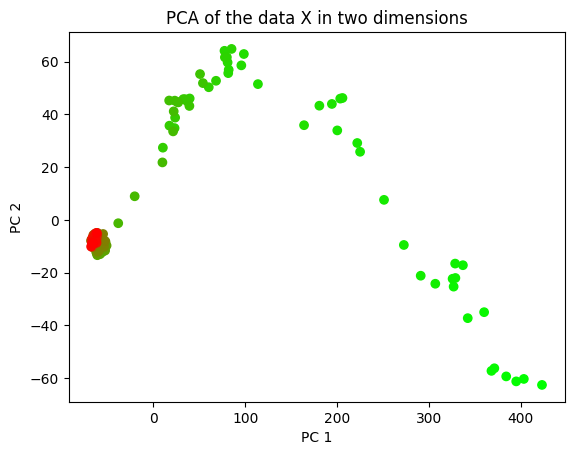

In [ ]:
# 3
# Transform the data X
X_transformed = pca_analysis.transform(X)

colors = np.array([np.linspace(0, 1, X_transformed.shape[0]), np.linspace(1, 0, X_transformed.shape[0]), np.zeros(X_transformed.shape[0])])

# Use the first two PCs to plot the data in 2D
plt.scatter(X_transformed[:,0], X_transformed[:,1], marker='o', c=colors.T)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA of the data X in two dimensions")
plt.show()

# Exercise 1: PCA of folded/disordered simulation data

Repeat steps 1-3 above for your exercise trajectories from the MD notebook (folded & disordered at **one** of the temperatures.)

Do you see any regularities, e.g. dense regions of the plot? If yes, think about which part of the trajectory (beginning or end) they correspond to. Does this make sense based on what you know of those trajectories?

/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


(25, 9730) (25, 9730)
The number of PCs to account for variance at least 90% is  15
Actual variance is  0.909939371574514


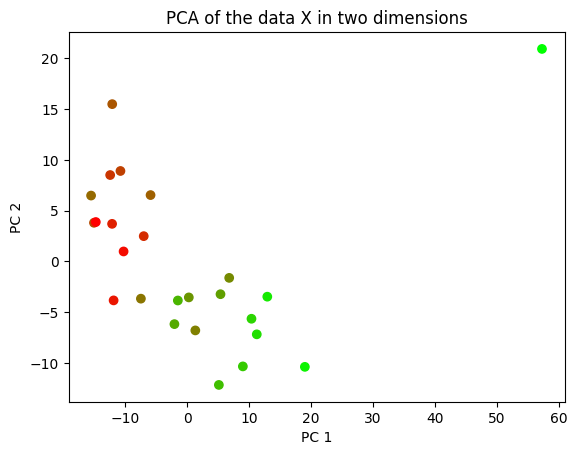

In [ ]:
# folded, 100 K

#1
# Loading coordinate and trajectory files into system

pdb_file = drive_path+'folded.pdb'
dcd_file = drive_path+'folded_100K.dcd'
sysf100 = md.Universe(pdb_file, dcd_file)

# Selecting only alpha carbons
CA_atoms = sysf100.select_atoms('name CA')

# Number of Alpha carbons atoms
N = len(CA_atoms)
M = len(sysf100.trajectory)

#Calculate pairwise distances
X = []
for frame in sysf100.trajectory:
    X.append(pdist(CA_atoms.positions))
X = np.array(X)

# ## More intuitive way to do that:
# X = np.empty((M, int(N * (N - 1) / 2)))

# using counter
k = 0

# for each frame of the trajectory
for frame in sysf100.trajectory:
    x = []
    # double loop for every pair i,j of atoms avoiding the duplicates
    for i in range(len(CA_atoms)):
        for j in range(len(CA_atoms)):
            if j > i :
                # find distance of the vector connecting two atoms
                d = np.linalg.norm(CA_atoms[i].position - CA_atoms[j].position)
                x.append(d)
    # making an numpy array and add that to the X
    x = np.array(x)
    X[k] = x
    k += 1

# Checking the dimensionality
print(X.shape, (M, int(N * (N - 1) / 2)))

# 2.
# Total number of components (N*(N-1)/2)
total_num_components = M
pca_analysis = PCA(n_components = total_num_components).fit(X)

# Run a cumulative sum to find a contribution of the first 1, then first 2, then first 3 and so on...
variance = np.cumsum(pca_analysis.explained_variance_ratio_)
components_90 = 0
for i, v in enumerate(variance):
    if (v > 0.9):
        components_90 = i + 1
        print("The number of PCs to account for variance at least 90% is ", components_90)
        print('Actual variance is ', v)
        break

# 3
# Transform the data X
X_transformed = pca_analysis.transform(X)

colors = np.array([np.linspace(0, 1, X_transformed.shape[0]), np.linspace(1, 0, X_transformed.shape[0]), np.zeros(X_transformed.shape[0])])

# Use the first two PCs to plot the data in 2D
plt.scatter(X_transformed[:,0], X_transformed[:,1], marker='o', c=colors.T)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA of the data X in two dimensions")
plt.show()

In [ ]:
# disordered, 100 K